In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split

In [10]:
class My_model(nn.Module):
    def __init__(self, input_dim):
        super(My_model, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1)  # (B,1) => (B)
        return x

In [40]:
class COVID19Dataset(Dataset):
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)
    def __getitem__(self, index):
        if self.y is None:
            return self.x[index]
        else:
            return self.x[index], self.y[index]
    def __len__(self):
        return len(self.x)

In [33]:
def train_valid_split(train_data, ratio):
    valid_size = int(ratio * len(train_data))
    train_size = len(train_data) - valid_size
    train_set, valid_set = random_split(train_data, [train_size, valid_size])
    return np.array(train_set), np.array(valid_set)

In [86]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'ratio': 0.3,
    'epochs': 5000,
    'batch_size': 256,
    'lr': 1e-4,
    'print_per_epoch': 50,
    'save_path': './models/model.ckpt'

}

In [41]:
tr_path = './hw1_dataset/covid_train.csv'
te_path = './hw1_dataset/covid_test.csv'

train_data = pd.read_csv(tr_path).values
test_data = pd.read_csv(te_path).values

train_data, valid_data = train_valid_split(train_data, config['ratio'])

train_dataset = COVID19Dataset(train_data[:,:-1], train_data[:,-1])
valid_dataset = COVID19Dataset(valid_data[:,:-1], valid_data[:,-1])
test_dataset = COVID19Dataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)


In [70]:
def train(train_loader, valid_loader, model, config):
    MSEloss = nn.MSELoss(reduce='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=1e-3)

    train_record = []
    valid_record = []

    n_epochs, best_loss = config['epochs'], math.inf

    for epoch in range(n_epochs):
        model.train()
        train_loss = []
        valid_loss = []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = MSEloss(y, pred)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.detach().item())
        
        mean_train_loss = sum(train_loss) / len(train_loss)
        train_record.append(mean_train_loss)

        model.eval()
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = MSEloss(pred, y)
                valid_loss.append(loss.item())
        mean_valid_loss = sum(valid_loss) / len(valid_loss)
        valid_record.append(mean_valid_loss)
        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path'])
            # print(f'Saving model with loss {mean_valid_loss:.4f}')


        if (epoch + 1) % config['print_per_epoch'] == 0:
            print(f'Epoch {epoch+1}/{n_epochs}: Train loss: {mean_train_loss:.4f} Valid loss: {mean_valid_loss:.4f}')
    
    return train_record, valid_record

In [ ]:
model = My_model(input_dim=train_data.shape[1]-1).to(device)
train_record, valid_record = train(train_loader, valid_loader, model, config)

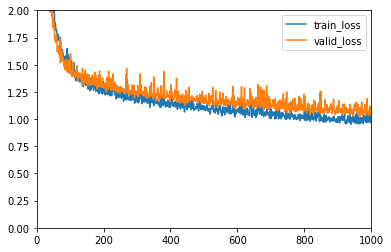

In [90]:
plt.plot(train_record[200:])
plt.plot(valid_record[200:])
plt.axis([0,1000,0,2])
plt.legend(['train_loss', 'valid_loss'])
plt.show()

In [ ]:
train_record